In [82]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import osmnx as ox
from shapely.ops import unary_union

In [83]:
fetch_data = False

# Get country boundaries

In [84]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_38428/3926210268.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [85]:
algeria = world[world.name == "Algeria"]

<Axes: >

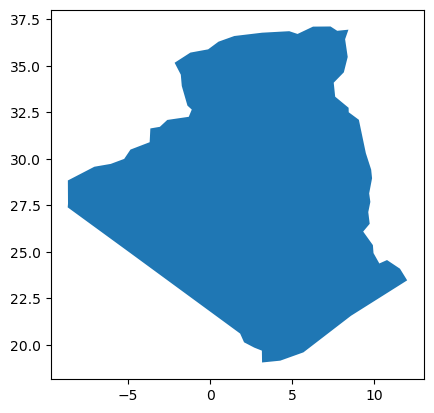

In [86]:
algeria.plot()

In [87]:
algeria_boundary = algeria.total_bounds

In [88]:
algeria_utm = algeria.estimate_utm_crs()

In [89]:
algeria_latitude = algeria.centroid.y.squeeze()

/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_38428/92571880.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  algeria_latitude = algeria.centroid.y.squeeze()


## Get Ookla data

In [90]:
#Ookla data
def get_perf_tiles_parquet_url(service: str, year: int, quarter: int) -> str:
    quarter_start = f"{year}-{(((quarter - 1) * 3) + 1):02}-01"
    url = f"s3://ookla-open-data/parquet/performance/type={service}/year={year}/quarter={quarter}/{quarter_start}_performance_{service}_tiles.parquet"
    return url

### Mobile

In [91]:
mobile_perf_tiles_url = get_perf_tiles_parquet_url("mobile", 2024, 2)

In [92]:
bbox_filters = [('tile_y', '<=', algeria_boundary[3]), ('tile_y', '>=', algeria_boundary[1]),
                ('tile_x', '<=', algeria_boundary[2]), ('tile_x', '>=', algeria_boundary[0])]

In [94]:
if fetch_data:
    mobile_tiles_df = pd.read_parquet(mobile_perf_tiles_url,
                           filters=bbox_filters,
                           columns=['tile_x', 'tile_y', 'tests', 'avg_d_kbps', 'avg_lat_ms'],
                           storage_options={"s3": {"anon": True}}
                           )
else:
    mobile_tiles_df = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-ookla-mobile-tiles.csv")

In [11]:
mobile_tiles_df.describe()

,tile_x,tile_y,tests,avg_d_kbps,avg_lat_ms
count,39449.000000,39449.000000,39449.000000,3.944900e+04,39449.000000
mean,0.775582,35.058193,5.430226,4.641057e+04,43.202134
std,6.206721,1.937065,10.143513,6.066411e+04,51.565808
min,-8.681900,19.562400,1.000000,7.000000e+00,0.000000
25%,-5.391500,33.904600,1.000000,1.358900e+04,23.000000
50%,1.551800,35.672900,2.000000,3.066700e+04,30.000000
75%,5.885900,36.591300,6.000000,5.678500e+04,44.000000
max,11.994300,37.114300,548.000000,1.141484e+06,2794.000000


In [13]:
mobile_tiles_gdf = gpd.GeoDataFrame(mobile_tiles_df, geometry=gpd.points_from_xy(mobile_tiles_df.tile_x, mobile_tiles_df.tile_y), crs="EPSG:4326").drop(columns=["tile_x", "tile_y"])

In [15]:
tile_size_at_latitude=610.8*np.cos(math.radians(algeria_latitude))
buffers = mobile_tiles_df.to_crs(algeria_utm).buffer(tile_size_at_latitude).to_crs("EPSG:4326")
single_polygon = unary_union(buffers)
gdf_single = gpd.GeoDataFrame(geometry=[single_polygon])

<Axes: >

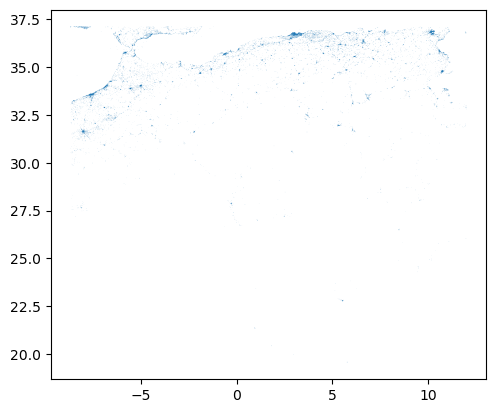

In [19]:
gdf_single.plot()

In [21]:
gdf_single["coverage"] = True

In [23]:
gdf_single.to_file("algeria_coverage.geojson", driver="GeoJSON")

/Users/sgpeytrignet/miniconda3/envs/inframaptraining/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


### Fixed

In [97]:
fixed_perf_tiles_url = get_perf_tiles_parquet_url("fixed", 2024, 2)

In [98]:
if fetch_data:
    fixed_tiles_df = pd.read_parquet(fixed_perf_tiles_url,
                           filters=bbox_filters,
                           columns=['tile_x', 'tile_y', 'tests', 'avg_d_kbps', 'avg_lat_ms'],
                           storage_options={"s3": {"anon": True}}
                           )
else:
    fixed_tiles_df = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-ookla-fixed-tiles.csv")

In [28]:
fixed_tiles_df.describe()

,tile_x,tile_y,tests,avg_d_kbps,avg_lat_ms
count,49914.000000,49914.000000,49914.000000,4.991400e+04,49914.000000
mean,0.129349,35.021032,27.066454,5.304698e+04,34.861762
std,6.505310,1.964576,56.033605,8.409739e+04,61.581864
min,-8.681900,19.567600,1.000000,1.000000e+00,0.000000
25%,-5.924400,33.813400,2.000000,1.018200e+04,15.000000
50%,-0.741550,35.668500,7.000000,1.990450e+04,24.000000
75%,5.737600,36.635400,26.000000,5.418375e+04,37.000000
max,11.994300,37.114300,2333.000000,1.095543e+06,2758.000000


In [36]:
fixed_tiles_df_high_speed = fixed_tiles_df.loc[fixed_tiles_df["avg_d_kbps"]/1000>50]

In [37]:
transmission_nodes_gdf = gpd.GeoDataFrame(fixed_tiles_df_high_speed, geometry=gpd.points_from_xy(fixed_tiles_df_high_speed.tile_x, fixed_tiles_df_high_speed.tile_y), crs="EPSG:4326").drop(columns=["tile_x", "tile_y"])

<Axes: >

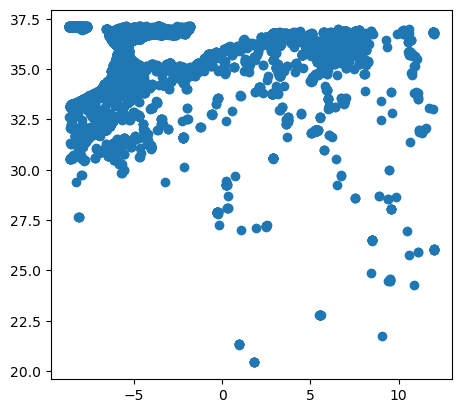

In [38]:
transmission_nodes_gdf.plot()

## POI data

In [68]:
if fetch_data:
    place = "Algeria"
    tags = {"amenity": "school"}
    schools = ox.features_from_place(place, tags)
else:
    schools = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-schools.csv")

/Users/sgpeytrignet/miniconda3/envs/inframaptraining/lib/python3.9/site-packages/osmnx/_overpass.py:254: UserWarning: This area is 1,079 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


KeyboardInterrupt: 

## Cell site data

In [ ]:
cell_sites = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-cell-sites.csv")

In [ ]:
# Geography checks
# Any outside of country boundaries
# Any in the sea?
# Any points too close to each other?
# Display the most remote point...

In [ ]:
# Other checks
# Desc stats, abnormal values...
# Check for duplicates